# Choosing between shared and group-specific labels, after observing two groups

January 2025

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from memo import memo
import jax
import jax.numpy as jnp
import optax

from enum import IntEnum
from tqdm import tqdm

import utils

pd.set_option('future.no_silent_downcasting', True)
sns.set_context('talk')

## Model

In [2]:
class TangramTypes(IntEnum):
    shared = 0
    unique = 1


class Responses(IntEnum):
    shared = 0
    unique = 1  


class AudienceConditions(IntEnum):
    either = 0
    one = 1


class Audiences(IntEnum):
    ingroup = 1
    outgroup = 0

In [3]:
# type: ignore

@jax.jit
def audience_wpp(audience_condition, audience):
    # for the "either group" condition, return 1 regardless of audience
    # for the "one group" condition, return 1 for the ingroup and 0 for the outgroup
    return jnp.array([1, audience])[audience_condition]


@jax.jit
def ref_info(audience, utterance):
    ingroup_info = jnp.array([1, 1])  # [shared, group-specific]
    outgroup_info = jnp.array([1, 0])

    info = jax.lax.cond(
        audience == Audiences.ingroup,
        lambda _: ingroup_info,
        lambda _: outgroup_info,
        operand=None,
    )

    return info[utterance]


@jax.jit
def social_info(utterance):
    return jnp.array([0, 1])[utterance]



@memo
def speaker[
    utterance: Responses, audience: Audiences
](audience_condition: AudienceConditions, alpha, w_r, w_s):
    cast: [speaker]
    speaker: chooses(
        audience in Audiences, wpp=audience_wpp(audience_condition, audience)
    )
    speaker: chooses(
        utterance in Responses,
        wpp=exp(
            alpha
            * (
                w_r * ref_info(audience, utterance)
                + w_s * social_info(utterance)
            )
        ),
    )
    return Pr[speaker.utterance == utterance]


## Load data

In [4]:
data = pd.read_csv("../data/3pp/shared-unique/selection_trials_clean.csv")
data.replace({"response.unique": {"shared": Responses.shared, "unique": Responses.unique}}, inplace=True)
data["response.unique"] = data["response.unique"].astype(int)

data.head()

,subject_id,item_id,counterbalance,condition,audience_group,shared.tangram,unique.tangram,response.unique
0,32503cf8-82cd-4aea-b515-9b247c56f89c,0,b,social one,red,H,L,1
1,32503cf8-82cd-4aea-b515-9b247c56f89c,0,b,refer one,red,D,L,1
2,32503cf8-82cd-4aea-b515-9b247c56f89c,0,b,refer one,blue,A,L,0
3,32503cf8-82cd-4aea-b515-9b247c56f89c,0,b,refer either,red,A,B,0
4,32503cf8-82cd-4aea-b515-9b247c56f89c,0,b,social one,red,A,L,1


Make a jax array for each condition

In [5]:
refer_either_mask = data["condition"] == "refer either"
refer_one_mask = data["condition"] == "refer one"
social_one_mask = data["condition"] == "social one"

refer_either_responses = jnp.array(data[refer_either_mask]["response.unique"].values)
refer_one_responses = jnp.array(data[refer_one_mask]["response.unique"].values)
social_one_responses = jnp.array(data[social_one_mask]["response.unique"].values)

## Predict

Define speaker functions

In [6]:
@jax.jit
def speaker_refer_either(data, w_r, w_s): 
    return speaker(
        audience_condition=AudienceConditions.either,
        alpha=1,
        w_r=w_r,
        w_s=0
    )[1, 0]

@jax.jit
def speaker_refer_one(data, w_r, w_s): 
    return speaker(
        audience_condition=AudienceConditions.one,
        alpha=1,
        w_r=w_r,
        w_s=0
    )[1, 0]

@jax.jit
def speaker_social_one(data, w_r, w_s): 
    return speaker(
        audience_condition=AudienceConditions.one,
        alpha=1,
        w_r=0,
        w_s=w_s
    )[1, 0]

speaker_refer_either_vmap = jax.vmap(speaker_refer_either, in_axes=(0, None, None))
speaker_refer_one_vmap = jax.vmap(speaker_refer_one, in_axes=(0, None, None))
speaker_social_one_vmap = jax.vmap(speaker_social_one, in_axes=(0, None, None))

Compute preds

In [7]:
class ModelTypes(IntEnum):
    base = 0
    social = 1
# later: move this into utils

In [8]:
@jax.jit
def predict_all(model_type, w_r, w_s): 
    # Note that the responses data isn't actually used here, it's just to get the shape of the data
    preds_refer_either = speaker_refer_either_vmap(refer_either_responses, w_r, w_s)
    preds_refer_one = speaker_refer_one_vmap(refer_one_responses, w_r, w_s)
    preds_social_one = jax.lax.cond(
        model_type == ModelTypes.base,
        lambda _: speaker_refer_one_vmap(social_one_responses, w_r, w_s),
        lambda _: speaker_social_one_vmap(social_one_responses, w_r, w_s),
        operand=None,
    )
    return preds_refer_either, preds_refer_one, preds_social_one



@jax.jit
def compute_NLL_all(model_type, refer_either_responses, refer_one_responses, social_one_responses, w_r, w_s):
    preds_refer_either, preds_refer_one, preds_social_one = predict_all(model_type, w_r, w_s)
    NLL_refer_either = utils.compute_NLL(preds_refer_either, refer_either_responses)
    NLL_refer_one = utils.compute_NLL(preds_refer_one, refer_one_responses)
    NLL_social_one = utils.compute_NLL(preds_social_one, social_one_responses)
    return NLL_refer_either + NLL_refer_one + NLL_social_one

Fit params

In [9]:
def fit_params(
    model_type,
    initial_params,
    refer_either_responses,
    refer_one_responses,
    social_one_responses,
    lr=0.001,
    tol=1e-6,
    max_steps=10000,
):
    def loss_fn(params):
        return compute_NLL_all(
            model_type,
            refer_either_responses,
            refer_one_responses,
            social_one_responses,
            params[0],
            params[1]
        )

    grad_fn = jax.value_and_grad(loss_fn)
    params = jnp.array(initial_params, dtype=jnp.float32)
    optimizer = optax.adam(learning_rate=lr)
    opt_state = optimizer.init(params)

    prev_nll = None
    for step in range(max_steps):
        nll_value, nll_grads = grad_fn(params)
        updates, opt_state = optimizer.update(nll_grads, opt_state)
        params = optax.apply_updates(params, updates)
        # ensure all params are positive
        params = params.at[:].set(jnp.clip(params[:], 0, jnp.inf))

        if step % 100 == 0:
            print(f"Step {step}, NLL value: {nll_value}, Params: {params}")

        if prev_nll is not None and abs(nll_value - prev_nll) < tol:
            print(f"Converged at step {step} with NLL={nll_value}")
            break

        prev_nll = nll_value

    best_nll = loss_fn(params)
    return params, best_nll

In [10]:
best_params_base, best_nll_base = fit_params(
    ModelTypes.base,
    [1.0, 0],
    refer_either_responses,
    refer_one_responses,
    social_one_responses,
)

Step 0, NLL value: 2326.683349609375, Params: [1.001 0.   ]
Step 100, NLL value: 2320.54736328125, Params: [1.0990986 0.       ]
Step 200, NLL value: 2315.33056640625, Params: [1.1921189 0.       ]
Step 300, NLL value: 2310.8916015625, Params: [1.2802635 0.       ]
Step 400, NLL value: 2307.10400390625, Params: [1.363889 0.      ]
Step 500, NLL value: 2303.8603515625, Params: [1.4433398 0.       ]
Step 600, NLL value: 2301.07177734375, Params: [1.518945 0.      ]
Step 700, NLL value: 2298.6650390625, Params: [1.5910144 0.       ]
Step 800, NLL value: 2296.5791015625, Params: [1.6598349 0.       ]
Step 900, NLL value: 2294.763427734375, Params: [1.725671 0.      ]
Step 1000, NLL value: 2293.1767578125, Params: [1.7887653 0.       ]
Step 1100, NLL value: 2291.78466796875, Params: [1.8493394 0.       ]
Step 1200, NLL value: 2290.55859375, Params: [1.9075953 0.       ]
Step 1300, NLL value: 2289.474365234375, Params: [1.9637166 0.       ]
Step 1400, NLL value: 2288.51220703125, Params: [2.

In [11]:
best_params_social, best_nll_social = fit_params(
    ModelTypes.social,
    [1, 1],
    refer_either_responses,
    refer_one_responses,
    social_one_responses,
)

Step 0, NLL value: 2355.216796875, Params: [1.001 0.999]
Step 100, NLL value: 2334.768798828125, Params: [1.0990986 0.9016833]
Step 200, NLL value: 2318.39990234375, Params: [1.1921188 0.8122326]
Step 300, NLL value: 2305.6103515625, Params: [1.2802634 0.7315438]
Step 400, NLL value: 2295.82861328125, Params: [1.363889  0.6601751]
Step 500, NLL value: 2288.482666015625, Params: [1.4433398  0.59847355]
Step 600, NLL value: 2283.03076171875, Params: [1.5189451 0.5465019]
Step 700, NLL value: 2278.99169921875, Params: [1.5910145 0.5039855]
Step 800, NLL value: 2275.9658203125, Params: [1.659835   0.47030228]
Step 900, NLL value: 2273.64404296875, Params: [1.7256712  0.44452158]
Step 1000, NLL value: 2271.80322265625, Params: [1.7887654  0.42549455]
Step 1100, NLL value: 2270.2919921875, Params: [1.8493395  0.41197345]
Step 1200, NLL value: 2269.0146484375, Params: [1.9075954 0.4027325]
Step 1300, NLL value: 2267.90966796875, Params: [1.9637165  0.39666376]
Step 1400, NLL value: 2266.93969

Preds with best params

In [12]:
preds_refer_either_base, preds_refer_one_base, preds_social_one_base = predict_all(
    ModelTypes.base, *best_params_base
)

preds_refer_either_social, preds_refer_one_social, preds_social_one_social = predict_all(
    ModelTypes.social, *best_params_social
)

In [13]:
preds_df_base = pd.DataFrame(
    {
        "condition": ["refer either"] * len(preds_refer_either_base)
        + ["refer one"] * len(preds_refer_one_base)
        + ["social one"] * len(preds_social_one_base),
        "p_unique": np.concatenate(
            [preds_refer_either_base, preds_refer_one_base, preds_social_one_base]
        ),
        "model": "base"
    }
)

preds_df_social = pd.DataFrame(
    {
        "condition": ["refer either"] * len(preds_refer_either_social)
        + ["refer one"] * len(preds_refer_one_social)
        + ["social one"] * len(preds_social_one_social),
        "p_unique": np.concatenate(
            [preds_refer_either_social, preds_refer_one_social, preds_social_one_social]
        ),
        "model": "social"
    }
)

preds_df = pd.concat([preds_df_base, preds_df_social])
preds_df = preds_df.drop_duplicates()
# save to csv
preds_df.to_csv("preds-3pp-red-blue-shared-unique.csv", index=False)

In [14]:
preds_df

,condition,p_unique,model
0,refer either,0.267588,base
1170,refer one,0.500000,base
2340,social one,0.500000,base
0,refer either,0.267178,social
1170,refer one,0.500000,social
2340,social one,0.595727,social


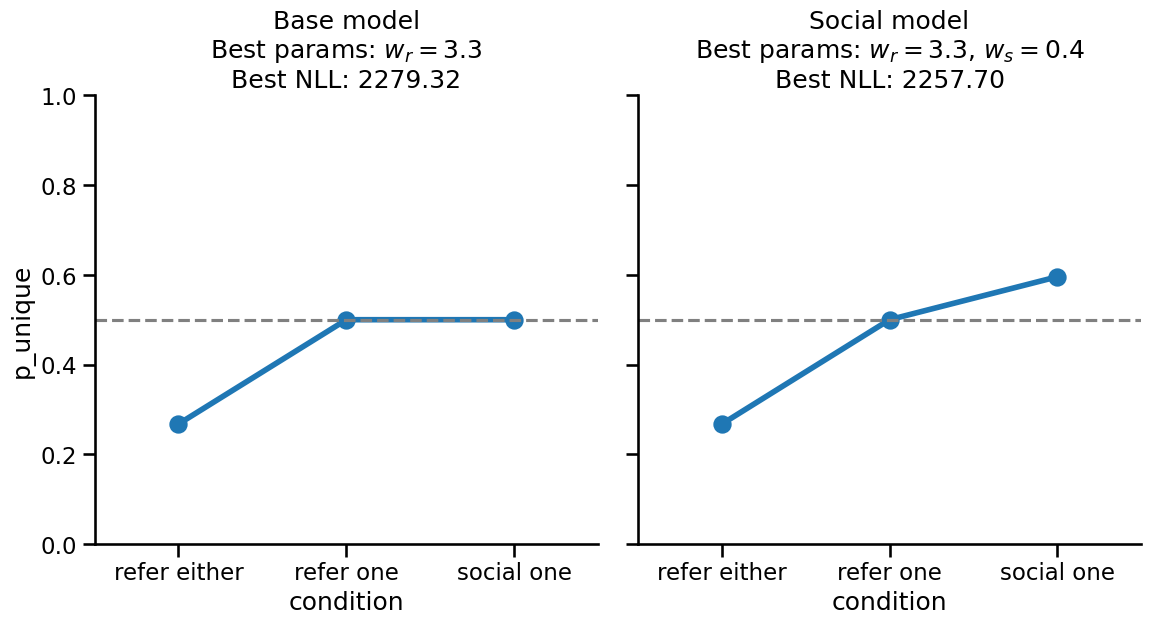

In [15]:
# Create a FacetGrid without hue to control colors
g = sns.FacetGrid(
    preds_df, col="model", height=6, aspect=1, sharey=True
)

# Map a point plot to the FacetGrid
g.map_dataframe(
    sns.pointplot, 
    x="condition", 
    y="p_unique", 
    dodge=True, 
    markers="o", 
    linestyles="-", 
)

# Set y-axis limits
g.set(ylim=(0, 1))

# Add a horizontal dashed line at 0.5
for ax in g.axes.flat:
    ax.axhline(0.5, ls="--", color="gray")

# Set custom titles
titles = [
    f"Base model\nBest params: $w_r={best_params_base[0]:.1f}$\nBest NLL: {best_nll_base:.2f}",
    f"Social model\nBest params: $w_r={best_params_social[0]:.1f}$, $w_s={best_params_social[1]:.1f}$\nBest NLL: {best_nll_social:.2f}"
]
for ax, title in zip(g.axes.flat, titles):
    ax.set_title(title)

plt.show()

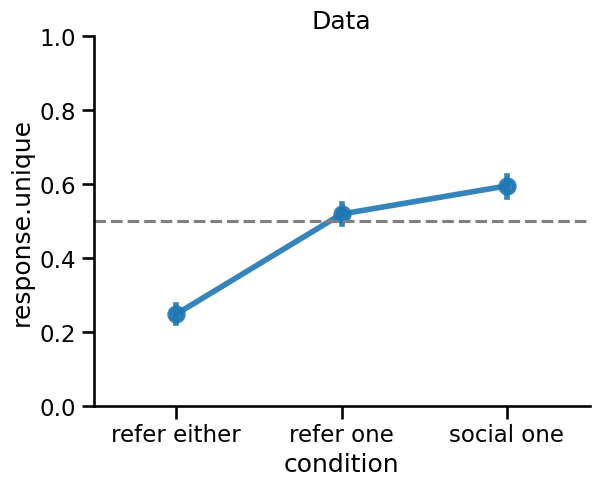

In [16]:
g = sns.pointplot(
    data=data,
    x="condition",
    y="response.unique",
    errorbar="ci",
    alpha=0.9, 
    order=["refer either", "refer one", "social one"], 
)
g.set(ylim=(0, 1), title="Data")
g.axhline(0.5, ls="--", color="gray")
sns.despine()

## LR test

In [17]:
from scipy.stats import chi2
lr_stat = 2 * (best_nll_base - best_nll_social)
df = 1
p = 1 - chi2.cdf(lr_stat, df)
print(f"LR test: χ²({df}) = {lr_stat}, p = {p}")

LR test: χ²(1) = 43.244140625, p = 4.831823829931636e-11
